In [1]:
import keras
from keras import layers
from keras import backend as k
from keras.models import Model
import numpy as np

Using TensorFlow backend.
C:\Users\EF\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\EF\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\EF\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\EF\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: Future

VAE encoder network

In [3]:
# Dimensionality of the latent space: 2D plane

img_shape = (28,28,1)       
batch_size= 16
latent_dim= 2

input_img = keras.Input(shape=img_shape)
x= layers.Conv2D(32,3, padding='same', activation='relu')(input_img)
x=layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2,2))(x)
x= layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x=layers.Conv2D(64,3, padding='same', activation='relu')(x)
shape_before_flattening=k.int_shape(x)

x= layers.Flatten()(x)
x= layers.Dense(32, activation='relu')(x)

# input image ends up being encoded into these 2 parameters.
z_mean= layers.Dense(latent_dim)(x)
z_log_var= layers.Dense(latent_dim)(x)

Latent-space sampling function

In [4]:
def sampling(args):
    z_mean, z_log_var= args
    epsilon= k.random_normal(shape=(k.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean  + k.exp(z_log_var) * epsilon
z= layers.Lambda(sampling)([z_mean, z_log_var])

VAE decoder network, mapping latent space points to images

In [6]:
decoder_input= layers.Input(k.int_shape(z)[1:])  # input where z is fed

x= layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)  # upsampling the input

x= layers.Reshape(shape_before_flattening[1:])(x)

x= layers.Conv2DTranspose(32,3, padding='same', activation='relu', strides=(2,2))(x)  # Uses a Conv2DTranpose layer and Conv2D layer to decodez into a feature map the same size as original  input.

x= layers.Conv2D(1,3, padding='same', activation='sigmoid')(x)

decoder= Model(decoder_input, x)      # Instantiates the decoder model, which turns 'decoder_input' into the decoded image.

z_decoded= decoder(z)   # Applies it to z to recover the decoded z

Custom layer used to compute the VAE loss

In [13]:

class CustomVariationalLayer(keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded):
        x= k.flatten(x)
        z_decoded = k.flatten(z_decoded)
        xent_loss= keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss= -5e-4 * k.mean( 1 + z_log_var - k.square(z_mean) - k.exp(z_log_var), axis= -1)
        return k.mean(xent_loss + kl_loss)
    
    def call(self, inputs):            # implement custom layers by writing a call method
        x= inputs[0]
        z_decoded= inputs[1]
        loss= self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x     # am not using this output, but using x because function must return something.

y = CustomVariationalLayer()([input_img, z_decoded]) # calls the custom layer on the input and the decoded output to obtain the final model output.

Training the VAE

In [14]:
from keras.datasets import mnist

In [15]:


vae = Model(input_img, y)
vae.compile(optimizer= 'rmsprop', loss=None)
vae.summary()

(x_train, _), (x_test, y_test) = mnist.load_data()

x_train= x_train.astype('float32') / 255.
x_train= x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test =   x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None, shuffle=True, epochs=5, batch_size= batch_size, validation_data=(x_test, None))
    
    

C:\Users\EF\anaconda3\lib\site-packages\keras\engine\training_utils.py:819: UserWarning: Output custom_variational_layer_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer_1.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 28, 28, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_4[0][0]                   
____________________________________________________________________________________________

sampling a grid of points from the 2D latent space and decoding  them to image

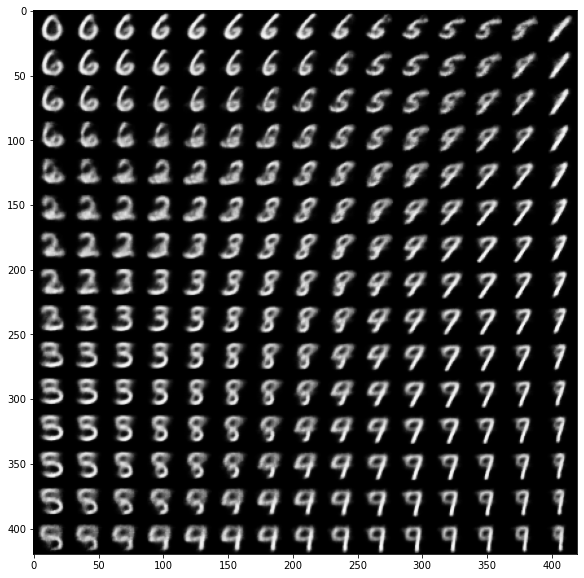

In [19]:
import matplotlib.pyplot as plt
from scipy.stats import norm

n=15
digit_size= 28               # will display 15x15 grid(255 total)

# transforms  linearly  spaced coordinates using scipy ppf function to produce values of the latent variable z (prior was gaussian)
figure= np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y= norm.ppf(np.linspace(0.05, 0.95,n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample= np.array([xi,yi])
        z_sample= np.tile(z_sample,batch_size).reshape(batch_size, 2)     #  repeats z  many times to form  complete batch
        x_decoded= decoder.predict(z_sample, batch_size=batch_size)     # decodes batch into digit images
        digit= x_decoded[0].reshape(digit_size,  digit_size)              #reshaping the first digit from 28x28x1 to 28x28
        figure[i  * digit_size: (i +1) * digit_size, j *  digit_size: (j +1) *digit_size]= digit

plt.figure(figsize=(10,10))
plt.imshow(figure, cmap='Greys_r')
plt.show()